# THIS CELL FETCHES DATA

0. --------------------- USING TENSORFLOW FORMAT ---------------------  
1. X: (22750, 1, 33, 33)  y: (22750, 1089)
1. X_train: (22750, 1, 33, 33)  y_train: (22750, 1089)
1. X_test: (0, 1, 33, 33)  y_test: (0, 1089)


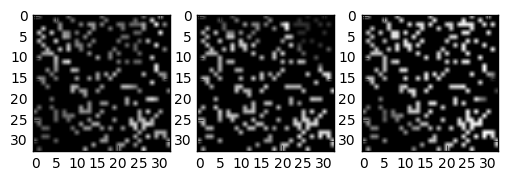

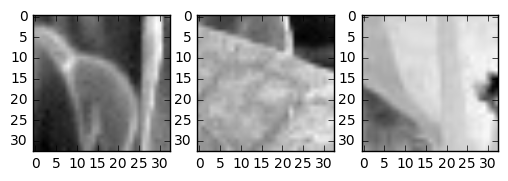

In [6]:
import sys
import os

%matplotlib inline
sys.path.append(os.path.dirname(os.getcwd()))

import utils
X_train, y_train, X_test, y_test = utils.get_data(33, 33, 'tensorflow', 'mr20', 0.0)

# THIS CELL TRAINS ON DATA 

In [7]:
# %load_ext autoreload
# %autoreload 2

def model_train(X_train, y_train, model_filename_weights, epochs = 1, batch_size = 32, callbacks_list=[]):
    ## CNN STRUCTURE ###
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Flatten
    from keras.layers import Convolution2D, MaxPooling2D
    from keras.optimizers import Adam
    
    model = Sequential()
    
    model.add(Convolution2D(64, kernel_size=(11, 11), activation='relu', use_bias = True
                                , input_shape=(1,33,33), data_format='channels_first', padding='same')
                                # , input_shape=(33,33,1), data_format='channels_last', padding='same')
                            )
    print ('First layer:', model.output_shape)
    # print ('First layer:', model.layers[0].output_shape)

    model.add(Convolution2D(32, kernel_size=(1, 1), activation='relu', use_bias = True, padding='same'))

    model.add(Convolution2D(1, kernel_size=(7, 7), activation='relu', use_bias = True, padding='same'))

    model.add(Convolution2D(64, kernel_size=(11, 11), activation='relu', use_bias = True, padding='same'))

    model.add(Convolution2D(32, kernel_size=(1, 1), activation='relu', use_bias = True, padding='same'))

    model.add(Convolution2D(1, kernel_size=(7, 7), activation='relu', use_bias = True, padding='same'))
    
    model.add(Flatten())
    
    # model.add(Dense(WIDTH*HEIGHT, activation='sigmoid'))
    
    ## CHECK IF NEW / OLDER MODEL ##
    if model_filename_weights == '':
        pass
    else:
        model.load_weights(model_filename_weights)

    ## CONTINUE WITH COMPILATION AND TRAINING ##
    opt = Adam(lr=1e-3)
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

    model.summary()

    X_train_model = X_train.astype('float32')
    X_train_model /= 255  
    y_train_model = y_train.astype('float32')
    y_train_model /= 255

    history = model.fit(X_train_model, y_train_model, batch_size=batch_size, epochs = epochs
                      , shuffle=True
                      , validation_split=0.1
                      , callbacks=callbacks_list
                      , verbose=1)
        
    return model, history
    

def model_validate(model, X_test, y_test):
    print ('\n4. --------------------------------------> Validating model')
    X_test_model = X_test.astype('float32')
    X_test_model /= 255  
    y_test_model = y_test.astype('float32')
    y_test_model /= 255
    metrics = model.evaluate(X_test_model, y_test_model, verbose=1)
    print ('\nValidation Metrics:', metrics)    

def model_disk(action, filename_model_arch, filename_model_weights, model=''):
    from keras.models import model_from_json
    
    print ('\n3. --------------------------------------> Model on Disk')
    if action == 'save':
        with open(filename_model_arch, "w") as handle:
            handle.write(model.to_json())
        model.save_weights(filename_model_weights)
        print("\nSaved model to disk")
        
    elif action == 'load':
        json_file = open(filename_model_arch, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.load_weights(filename_model_weights)
        print("Loaded model from disk")
    
    return model

def model_run(MODEL_NEW, TEST, EPOCHS, BATCH_SIZE, MODEL_FOLDER, model_filename_weights_best):
    ## CHECK TENSORFLOW DEVICES ##
    if (utils.check_gpu(verbose = 0)):
        from keras.callbacks import ModelCheckpoint
        
        ## 1.1 TRAIN MODEL : NEW MODEL OR OLD ##
        if MODEL_NEW == 1:
            print ('2. --------------------------------------> Fresh model')
            model_filename_weights_best = ''
        else:
            print ('2. --------------------------------------> Updating model(',model_filename_weights_best,')')
            model_filename_weights_best = model_filename_weights_best

        ## 1.2 TRAIN MODEL : CREATE CHECKPOINTING INFO ##
        model_filename_weights = MODEL_FOLDER + "/index_network_euclidean_keras_weights_{epoch:02d}_{val_acc:.2f}.hdf5"
        # model_filename_weights = "model/index_network_euclidean_keras_weights_{epoch:02d}.h5"
        checkpoint = ModelCheckpoint(model_filename_weights, monitor='val_acc', mode='auto'
                                     # , save_best_only = True
                                     , save_best_only = False
                                     , save_weights_only = True, verbose=0.1)
        callbacks_list = [checkpoint]

        ## 1.3 TRAIN MODEL : TEST OR PROD MODEL ##
        if TEST == 1:
            model, history = model_train(X_train[:BATCH_SIZE*3], y_train[:BATCH_SIZE*3], model_filename_weights_best, epochs = EPOCHS, batch_size = BATCH_SIZE
                                , callbacks_list = callbacks_list)
        else:
            model, history = model_train(X_train, y_train, model_filename_weights_best, epochs = EPOCHS, batch_size = BATCH_SIZE
                                , callbacks_list = callbacks_list)

        ## 1.4 TRAIN MODEL : SAVE MODEL AND WEIGHTS FOR ANY FUTURE REFERENCES  ##
        filename_model_arch = MODEL_FOLDER + '/index_network_euclidean_keras_model.json'
        filename_model_weights = MODEL_FOLDER + '/index_network_euclidean_keras_weights.h5'
        model = model_disk('save', filename_model_arch, filename_model_weights, model)
        model_validate(model, X_test, y_test)
        
        return model
    
    else:
        print ('0. GPU not available :( ')
        return None

if __name__ == "__main__":
    from glob import glob
    import numpy as np
    
    MODEL_NEW = 1
    TEST = 0
    EPOCHS = 70
    BATCH_SIZE = 128
    MODEL_FOLDER = 'model_mr20'
    
    if not (os.path.exists(MODEL_FOLDER)):
        os.makedirs(MODEL_FOLDER)
        MODEL_NEW = 1

    if MODEL_NEW == 1:
        model_filename_weights_best = ''
    else:
        model_filename_weights_best = sorted(glob(MODEL_FOLDER + '/index_network_euclidean_keras_weights_*')
                                             , key=os.path.getmtime)[-1]
        # model_filename_weights_best = 'model/index_network_euclidean_keras_weights_09.h5'

    model = model_run(MODEL_NEW, TEST, EPOCHS, BATCH_SIZE, MODEL_FOLDER, model_filename_weights_best)


0. Keras backend: tensorflow
0. TensorFlow Devices: /cpu:0
0. TensorFlow Devices: /gpu:0


2. --------------------------------------> Fresh model
First layer: (None, 64, 33, 33)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 33, 33)        7808      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 33, 33)        2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 33, 33)         1569      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 33, 33)        7808      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 33, 33)        2080      
_________________________________________________________________
conv2d_6 (Conv2D)            

# THIS CELL TESTS THE NETWORK


3. --------------------------------------> Model on Disk
Loaded model from disk
(1, 1089) (1089,)
X_predict: (1, 1089)


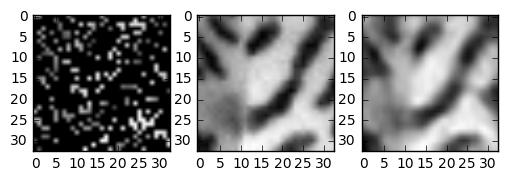

In [11]:
import joblib
import numpy as np
import matplotlib.pyplot as plt

def get_data_random(url_data_X, url_data_y, noise = 0):
    if noise == 0:
        with open(url_data_X, 'rb') as handle:
            X = joblib.load(handle)

        with open(url_data_y, 'rb') as handle:
            y = joblib.load(handle)

        rand_idx = np.random.randint(0, len(X))

        return X[rand_idx], y[rand_idx]
    
    else:
        np.random.random_integers(0, 255, (33,33))
    

if __name__ == "__main__":
    DATA_MR = 'mr20'
    MODEL_FOLDER = 'model_' + DATA_MR
    model = model_disk('load', MODEL_FOLDER + '/index_network_euclidean_keras_model.json'
                               , MODEL_FOLDER + '/index_network_euclidean_keras_weights.h5'
                               , ''
                       )
    url_data_X = '../data/' + DATA_MR + '/data_patches_X.gz'
    url_data_y = '../data/' + DATA_MR + '/data_patches_y.gz'
    X_rand, y_rand = get_data_random(url_data_X, url_data_y)
    print (X_rand.shape, y_rand.shape)
    
    X_predict = model.predict(X_rand.reshape(1,1,33,33))
    print ('X_predict:', X_predict.shape)
    
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(X_rand.reshape(33,33), cmap = plt.cm.gray)
    axarr[1].imshow(y_rand.reshape(33,33), cmap = plt.cm.gray)
    axarr[2].imshow(X_predict.reshape(33, 33), cmap = plt.cm.gray)

# THIS CELL IS FOR EXPERIMENTATION

In [ ]:
from keras import backend as K
K.function([K.learning_phase(), model.layers[0].input], model.layers[2].output)